# Chapter 2 - End to end Machine Learning Project

_The task of this project is to predict median house values in Californian districts, given a number of features from these districts_

## Setup

Typically data would be available in a relational database. Accessing it would require getting credentials, undestanding schema, etc. For simplicity, in this project we're working with CSV file called _housing.csv_.

It's usually preferrable to write a function for downloading and decompressing the data. Here is the function to fetch and download the data:

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

# Constants
DATASET_URL = "https://github.com/ageron/data/raw/main/housing.tgz"
DATASET_DIR = Path("datasets")
TARBALL_PATH = DATASET_DIR / "housing.tgz"
CSV_PATH = DATASET_DIR / "housing/housing.csv"

def download_and_extract_housing_data():
    if not TARBALL_PATH.is_file():
        DATASET_DIR.mkdir(parents=True, exist_ok=True)
        urllib.request.urlretrieve(DATASET_URL, TARBALL_PATH)
        with tarfile.open(TARBALL_PATH) as housing_tarball:
            housing_tarball.extractall(path=DATASET_DIR)

def load_housing_data():
    if not CSV_PATH.is_file():
        download_and_extract_housing_data()
    return pd.read_csv(CSV_PATH)

housing = load_housing_data()


## Quick Look at the Data Structure

Start by looking at the first five rows using DataFrame's `head()` method:

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The `info()` method is useful to get a quick description of the data, in particular the total number of rows, each attributes' type, etc.:

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


All attributes, except for `ocean_proximity` are numerical. You could have noticed from the top five rows above that the latter is a text and that it contains repetitive values.

Find out all its available values:

In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

The `describe()` method shows a summary of the numerical attributes:

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


You may also plot a histogram showing a number of instances (_y_ axis) that have a given value range (_x_ axis):

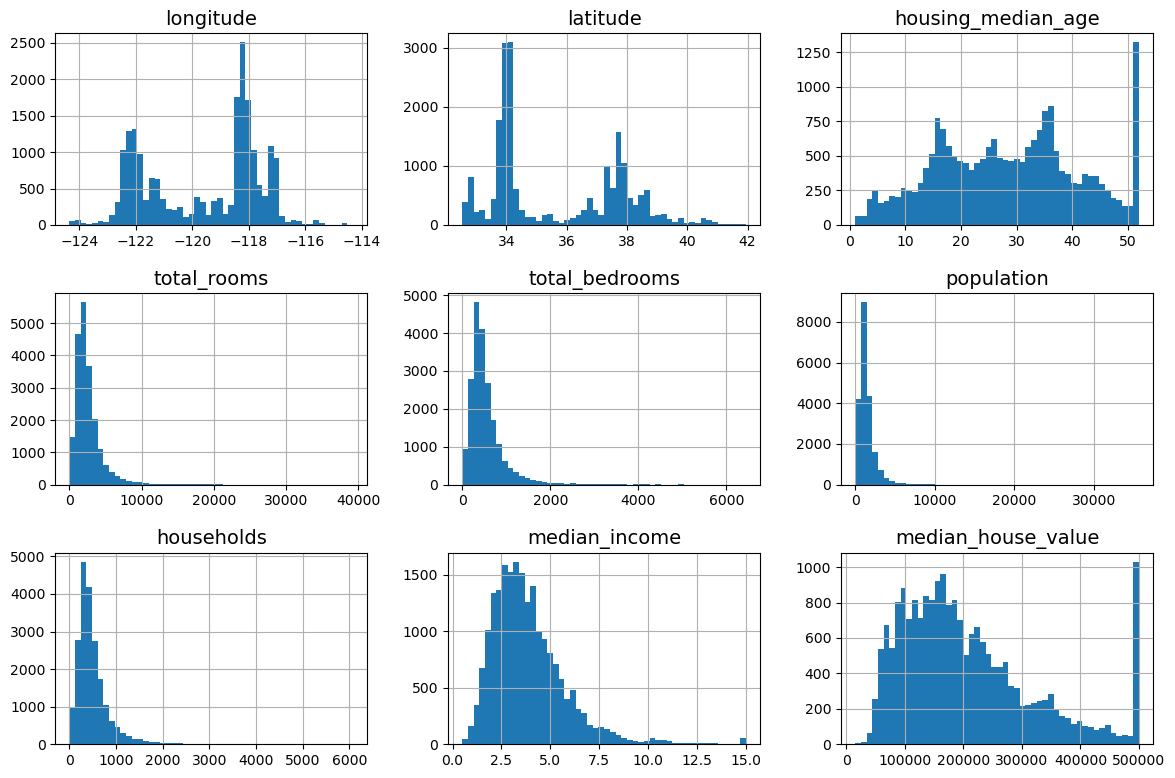

In [6]:
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# code to save figures as high resolution PNGs
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# the following 5 lines define the default font size
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12,8))
save_fig("attribute_histogram_plots")
plt.show()

## Create a Test Set

Create it as early as possible in the project to avoid _data snooping bias_.

To have a stable train/test split even after updating the dataset, a common solution is to use each instance's indentifier to decide whether it should or shouldn't go into the test set. When lacking an id you may compute one by calling `hash()` on the row.

By default Python's `hash()` function is randomized (a different salt is used each time). To remove this randomness, one solution is to set the `PYTHONHASHSEED` environment variable to `0`:

In [7]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [8]:
len(test_set)

4128

In [9]:
np.random.seed(42)

In [10]:
from zlib import crc32
import numpy as np

# identifier is assumed to be a number
def is_id_in_test_set(identifier, test_ratio):
    # consistently represent identifier as a 64-bit int
    # then compute a 32 bit checksum on it and
    # compare it to 2^32 times test_ratio
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# we would use row index as the ID for the absence of the identifier column
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

However, we will not be using this function, but rely on a bulit-in equivalent from `sklearn` library:

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set["total_bedrooms"].isnull().sum()

44

This is a purely random sampling method, but you're likely to hit a sampling bias. Instead you want to have a set reprenstative of the entire training set (US census men/women ratio).

We will assume that median income is a very important attribute to predict median housing pricing. We must ensure that our test set is representative of the various categories of incomes in teh whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. The following code uses `pd.cut()` function to create an income category attribute with five categories (labelled from 1 to 5); category 1 ranges from 0 to 1.5 (i.e. less than $15000), category 2 from 1.5 to 3, and so on:

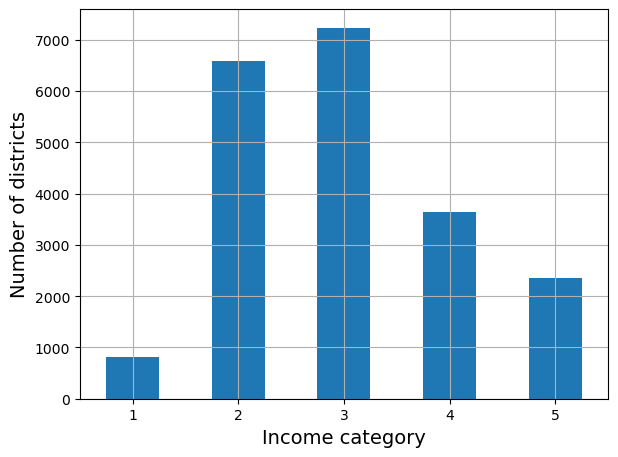

In [12]:
# housing["incomee_cat"] actually creates a new column in the `housing` DataFrame
# np.inf represents positive infinity
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot") 
plt.show()

Now we are ready to do stratified sampling based on the income category.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

# we can actually ignore all of the above, since there's already an available shorthand
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

Start looking at the income category proportions within test set:

In [14]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

Since we won't use the `income_cat` column again, we may drop it now

In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Explore and Visualize the Data to Gain Insights

At this stage only explore the training set. If the latter is too large, consider sampling an exploration set.

⚠️ Since you're experimenting with various transformations of the full training set, you should make a copy of the original so you can revert to it afterwards:

In [16]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

Because the dataset includes geographical information, it is a good idea to create a scatterplot (user dots) of all the districts to visualize the data

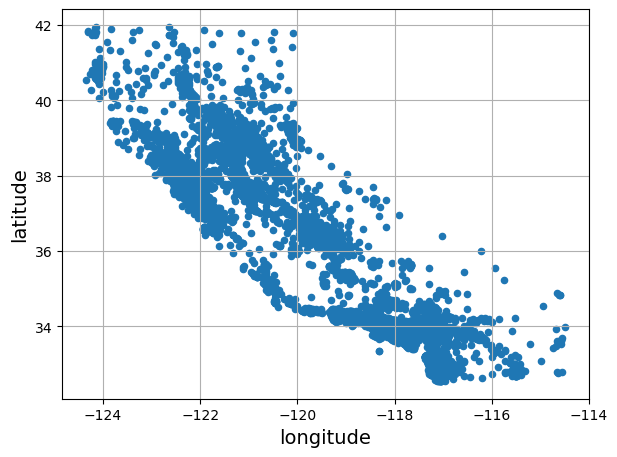

In [17]:
housing.plot(kind="scatter",x="longitude",y="latitude",grid=True)
save_fig("bad_visualization_plot") 
plt.show()

☝🏼 This looks ok, but it is hard to distinguish a pattern. Setting the `alpha` option to `0.2` makes it much easier to visualize the places where there is a hight density of data points:

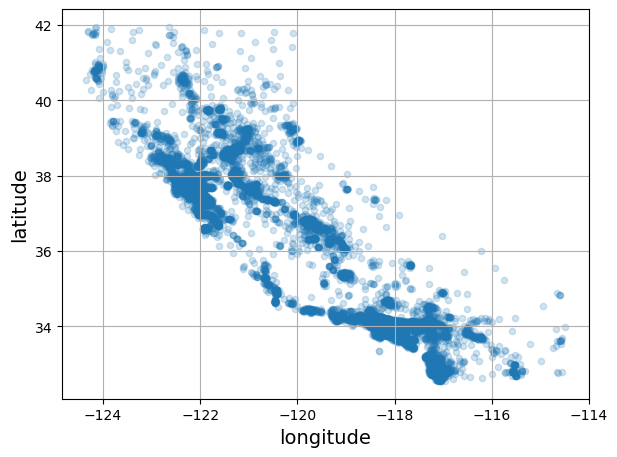

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot") 
plt.show()

Now let's look at the housing prices. The radius of each circle represents the district's population (option `s`), and the color represents the price (option `c`). Here we use a predefined color map (option `cmap`) callet `jet`, which ranges from blue (low values) to red (high prices):

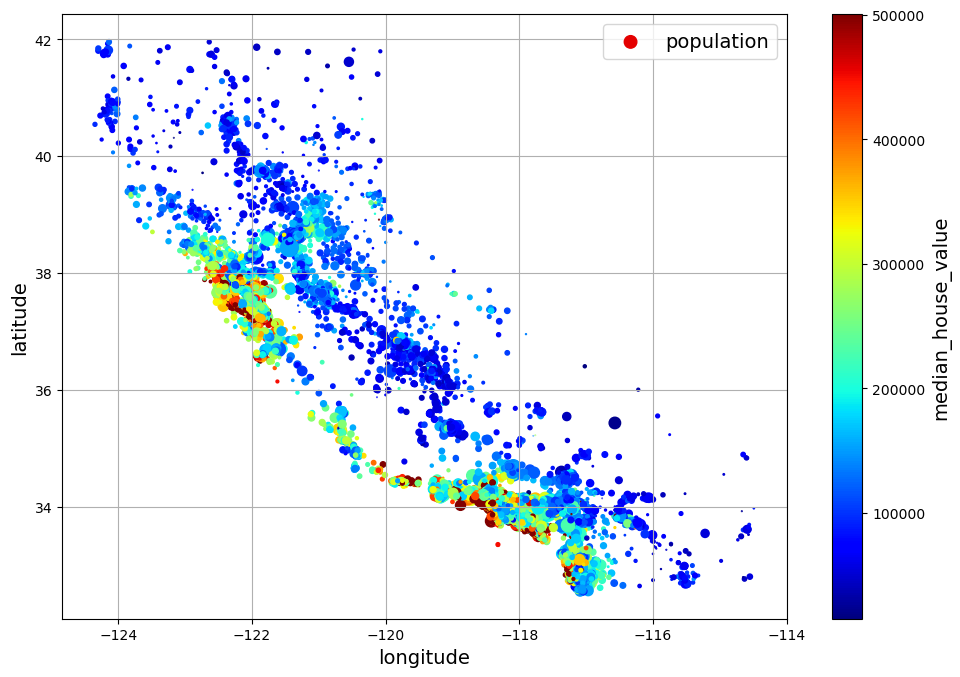

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"] / 100, label="population", c="median_house_value",cmap="jet",colorbar=True, legend=True, sharex=False, figsize=(10,7))
save_fig("housing_prices_scatterplot")
plt.show()

### Look for Correlations

Since the dataset is not too large, you can easily compute the _standard correlation coefficient_ (also called _Pearson's r_) between every pair of attributes using the `corr` method:

In [20]:
# need to pass `numeric_only`, check this issue: https://github.com/ageron/handson-ml3/issues/80
corr_matrix = housing.corr(numeric_only=True)

Correlation coefficients range between -1 and 1. When it is close to 1, it means that there is a strong positive correlation. For example, the median house value tends to go up when the median income goes up.

When the coefficient is close to -1, it means that there is a strong negative correlation. Finally 0 means there is no linear correlation.

Look at how much each attribute correlates with the `median_house_value`:

In [21]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Another way to check correlation is to use Panda's `scatter_matrix` function which plots every numeric attributes against each other. Since `11^2 = 121` we may focus on the most promising ones (the output from above):

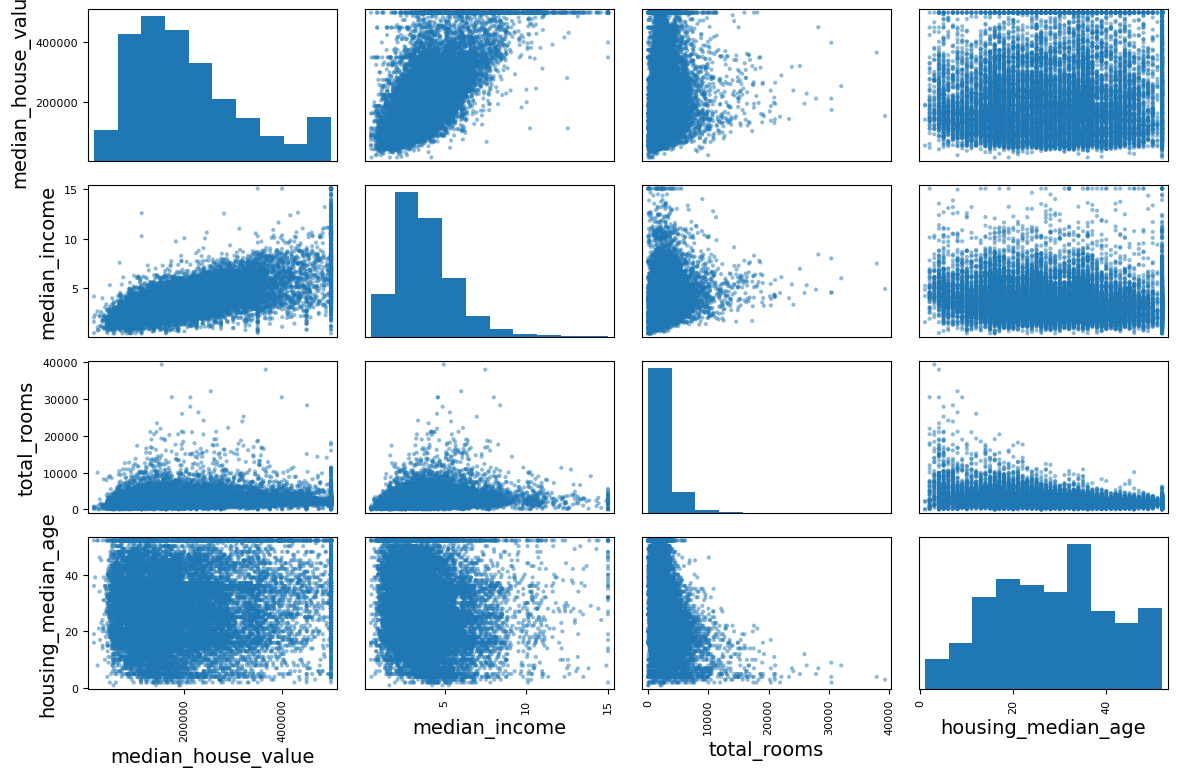

In [22]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")
plt.show()

This confirms that the most promising attribute to predict the median house value is the median income.

⚠️ The correlation coefficient only measures linear correlations. It may completely miss out nonlinear relationships.

### Experiment with Attribute Combinations

We've also noticed that some attributes have a skewed-right distribution, so we may want to transform them (e..g. by comparing their logarithm or square root).

Total number of rooms in a district is not every useful if you don't know how many households there are. What you really want is the number of rooms per household. Similarly you would want to compare number of bedrooms to the number of rooms. We may also want to look at population per houselhold metric:

In [23]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

☝🏼Check the new negative `bedrooms_ration` negative correlation!

## Prepare the Data for Machine Learning Algorithms

Don't do this manually, instead write functions to help you out, because:

- reproduce these transformations on any dataset
- build-up your own library of transformation functions for any future project

But first revert to a clean training set (by copying `strat_train_set` once again).

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Clean the Data

You can drop attributes or set missing (default) values using the Pandas DataFrame's `dropna()`, `drop()`, and `fillna()` methods:

In [25]:
# Consider uncomenting only ONE of the three approaches if rows' count mismatches later
# In the book 3 options are listed to handle the NaN values:
# housing.dropna(subset=["total_bedrooms"], inplace=True) # get rid of the corresponding districts
# housing.drop("total_bedrooms", axis=1) # get rid of the whole attribute
# median = housing["total_bedrooms"].median() # set the missing values to some value (zero, the mean, the median, etc.). This is called imputation
# housing["total_bedrooms"].fillna(median, inplace=True)

For each option, we'll create a copy of `housing` and work on that copy to avoid breaking `housing`. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [26]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [27]:
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True) # option 1
housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [28]:
housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", axis=1, inplace=True) # option 2
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [29]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True) # option 3

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


`median()` is the least destructive, but instead of the preceding code, you will use a handy Scikit-Learn class: `SimpleImputer`. The benefit is that it will store the median value of each feature:

In [30]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")
# the median can only be computed on numerical attributes, so first create copy of the data with only the numerical attributes
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
# imputer stores values including computed medians in its statistics_ instance variable
imputer.statistics_
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now you can use this "trained" imputer to transform the training set by replacing missing values with the learned medians:

In [31]:
X = imputer.transform(housing_num)

In [32]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [33]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


Other more powefule imputers are:

- `KNNImputer` - replaces each missing value with the mean of the _k_-nearest neighbors' values for that feature
- `IterativeImputer` - trains a regression model per feature to predict the missing values on all the other available features.

Most ML algorithms prefer to work with numbers, so let's convert these categories from text to numbers. For this, we can use Scikit-Learn's `OrdinalEncoder` class:

Now let's drop some outliers:

In [34]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

If you wanted to drop outliers, you would run the following code:

In [35]:
# housing = housing.iloc[outlier_pred == 1]
# housing_labels = housing_labesl.iloc[outlier_pred == 1]

### Handling Text and Categorical Attributes

In [36]:
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [37]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# first few encoded values:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [38]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [39]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [40]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [41]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [42]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Feature Scaling and Transformation

One of the most important transformations you need to apply to your data is _feature scaling_. With few exceptions, ML algorithms don't perform well when the input numerical attributes have very different scales.

There are two common ways to get all attributes to have the same scale: _min-max scaling_ and _standardization_.

⚠️ As with all estimators, it is important to fit the scalers to the training data only: never use `fit()` or `fit_transform()` for anything else than the training set. Once you have a trained scaler, you can then use it to `transform()` any other set, including the validation set, the test set, and new data.

Min-max scaling (also called _normalization_) is the simplest: for each attribute, the values are shifted and rescaled so that they end up ranging from 0 to 1. Scikit-Learn's `MinMaxScaler` has a feature `feature_range` hyperparameter that lets you change the range if needed (e.g. neural networks work best with zero-mean inputs so a range of -1 to 1 is preferrable).:

In [43]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

# example of a StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

Standardization is different: it subtracts the mean value (so standardized values have a zero mean), then it divides the result by the standard deviation (so standardized value have a standard deviation equal to 1). Standardization is much less affected by outliers.

When a feature's distribution has a _heavy tail_, both min-max and standardization will squash most values into a small range. ML models don't like this at all. So _before_ you scale the feature, you should first transform it to shring the heavy tail, and if possible to make the distribution roughly symmetrical. One could use a square root of the value instead of the value. If the feature has a really ling and heavy tail, such as a _power law distributioin_, then replacing the feature with its logarithm may help. For example, the `population` feature roughly follows a power law. Here is how much better this feature looks when you compute its log: it's very close to a Gaussian (bell-shaped) distribution.

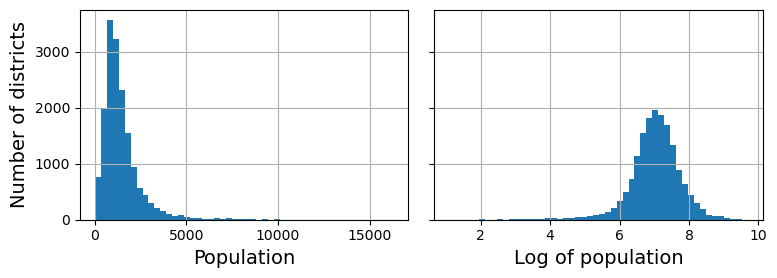

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

Another approach to transforming multimodal distributions is to add a feature for each of the models (at least the main ones), representing the similarity between the housing median age and that particular mode. The similarity measure is typically computed using a _radial basis function_ (RBF) - any function that depends only on the distance between the input value and a fixed point. The most commonly used RBF is the Gaussian RBF, whose value decays exponentially as the input value moves away from the fixed point.

The hyperparameter `gamma` determines how quicly the similarity measure decays as _x_ moves away from 35. Using Scikit-Learn's `rbf_kernel()` function, you can create a new Gaussian RBF feature measuring the similarity between the housing median age and 35:

In [45]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

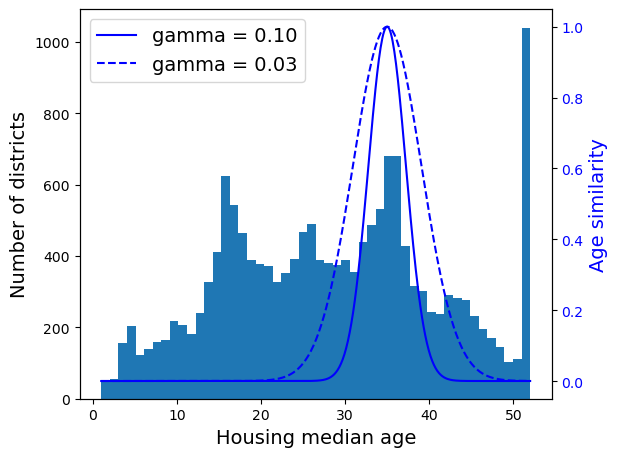

In [46]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

In [47]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [48]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [49]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [50]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers

A custom transformer can (and often does) use other estimators in its implementation. For example, the following code demonstrates custome transformer that uses a `KMeans` clusterer in the `fit()` method to identify the main clusters in the training data, and then uses `rbf_kernel` in the `transform()` method to measure how similar each sample is to each cluster center:

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

# usage, remember that housing_labels represent median_house_value
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

The code above weighs each district (cluster) by its median house value. The transformer uses _k-means_ to locate the clusters, then measures the Gaussian RBF similarity between each district and all 10 cluster centers.

The result is a matrix with one row per district, and one column per cluster. Let's look at the first three rows, rounding to two decimal places:

In [52]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

The figure below shows the 10 clouster centers found by _k_-means. The districts are colored according to their geographic similarity to their closes cluster center. As you can see, most clusters are located in highly populated and expensive areas.

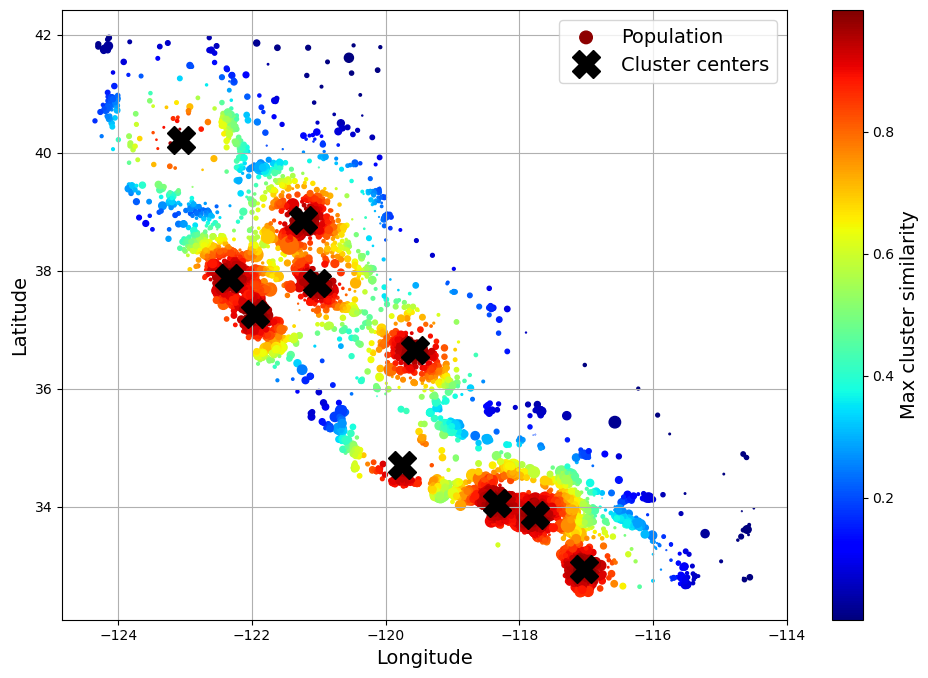

In [53]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

### Transformation Pipelines

As you can see there are many transformations to be executed in the right order. Scikit-Learn provides the `Pipeline` class to help with their sequence. Below is a simple pipeline for numerical attributes, which will first impute then scale the input feature:

In [54]:
from sklearn.pipeline import Pipeline

# stage keys can be any unique striings that doesb't contain double underscores (__)
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

ℹ️ In Jupyter notebook, if you `import.sklearn` and run `sklearn.set_confg(display="diagram")`, all Scikit-Learn estimators will be rendered as intereactive diagrams. If you want to omit keys use `make_pipeline` function as follows:

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn import set_config

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [56]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
# show first two rows and rouund each value to two decimal places
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [57]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)
df_housing_num_prepared.head(2)  # extra code

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [58]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In order to use a single transformer for both numerical and categorical columns, you can use `ColumnTransformer`. For example the below instance wil apply `num_pipeline` to the numerical attributes and `cat_pipeline` to the categorical attribute:

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

# the constructor takes a list of Tupple3: name, transformer, list of columns
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

Below is the entire preprocessing pipeline for the `housing` dataset:

In [60]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import FunctionTransformer

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline) # one column remaining : housing_median_age

Now if you run this `ColumnTransformer`, it performs all the transformations and outputs a NumPy array with 24 features:

In [61]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [62]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select and Train a Model

`LinearRegression()` yielded an unsatisfying performance measure (RMSE), so the next suggestion was to try a `DecisionTreeRegressor`, as this is fairly powerful capable of finding complex nonlinear relationships in the data:

In [63]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x727...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x727d961a81c0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

Now that the model is trained, you evalluate it on the training set:

In [64]:
from sklearn.metrics import mean_squared_error

housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

0.0

No errors in this case is unlikely to point at a perfect model, rather is is likely that it is a case of an overfit. We shouldn't touch the _test set_ to be sure (until we're ready that we are confident about our model choice). Instead we need to extract _validation set_ from our _training set_.

## Better Evaluation Using Cross-Validation

An alternative to splitting a _validation set_ is to use Scikit-Learn's `k_-fold cross-validation`:

In [65]:
# splits the training set into 10 subsets and trains and evaluates tree model 10 times, picking a different fold(subset) every time and using the other 9 folds for training.
# the result is an array containing the 10 evaluation scores:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     67153.318273
std       1963.580924
min      63925.253106
25%      66083.277180
50%      66795.829871
75%      68074.018403
max      70664.635833
dtype: float64

Now the decision tree doesn't look as good as it did earlier. In fact it seems to perform almost as poorly as the linear regression model. You wouldn't have this information if you just used one validation set.

We know that there's an overfitting problem because the training error is low (0) while the validation error is high. Let's try one last model for now: the `RandomForrestRegressor`. Random forrests work by training many decision trees on random subsets of the features, then averaging out their predictions. Such models composed of many other models are called _ensembles_: they are capable of boosting the performance of the underlying model:

In [66]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47002.931706
std       1048.451340
min      45667.064036
25%      46494.358345
50%      47093.173938
75%      47274.873814
max      49354.705514
dtype: float64

This is a much smaller deviation! Possible solutions for improvement are to simplify the model, constrain it (i.e. regularize), or get a lot more training data.

However, you should try out many other models from varios categories of machine learning algorithms (e.g. several support vector machines with different kernels, and possibly a neural network), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

## Fine-Tune Your Model

### Grid Search

One option would be to fiffle with the hyperparameters manually, until you find great combination of hyperparameter values. This would be very tedious work. Instead, you can use Scikit-Learn's `GridSearchCV` class to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values.

In [67]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6,8,10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x727d961a81c0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

Notice that you can refer to any hyperparameter of any estimator in a pipeline, even if this estimator is nested deep inside several pipelines and column transformers. For example. when Scikit-Learn sees "`preprocessing__geo_n_clusters`", it splits the string at the double underscores, then it looks for an estimator named "`preprocessing`" in the pipeline and finds the preprocessing `ColumnTransformer`. Next, it looks for a transformer named "`geo`" inside the `ColumnTransformer` and finds the `ClusterSimilarity` transformer we used on the latitude and longitude attributes. Then it finds this transformer's `n_clusters` hyperparameter.

If fitting the pipeline transformers is computationally expensive, you can set the pipeline's `memory` hyperparameter to the path of a caching directory: when you first fit the pipeline, Scikit-Learn will save the fitted transformers to this directory.

There are two dictionaries in this `param_grid`, so `GridSearchCV` will first evaluate `3 * 3 = 9` combinations, then it will try `2 * 3 = 6` combninations of hyperparameter values. So in total the grid search will explore `9 + 6 = 15` combinations of hyperparameter values, and it will train the pipeline 3 times per combination (`cv` value). This means there will be 45 rounds of validation.

This may have taken a while, but now you can get the best combination of parameters like this:

In [68]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

☝️ ℹ️ Since 15 is the maximum value that was evaluated for `n_clusters`, you should probably try searching again with higher valuesl the score may continue to improve

The evaluation scores are available using `grid_search.cv_results_`. This is a dictionary, but if you wrap it in a DataFrame you get a nice list of all the test scores for each combination of hyperparameters and for each cross-validation split, as well as the mean test score across all splits:

In [69]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
[...] # change column names to fit on this page, and rmse = -score
cv_res.head() # note: the 1st column is the row ID

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,5.099579,0.381760,0.088913,0.018714,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43535.728124,-43753.147171,-44568.889283,-43952.588193,444.738152,1
13,6.605173,0.151340,0.092911,0.022071,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-44084.115907,-44204.924326,-44862.665796,-44383.902009,342.110841,2
14,7.497942,0.391506,0.090482,0.020970,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44367.841163,-44496.254950,-45199.975902,-44688.024005,365.780976,3
7,5.380653,0.055075,0.104190,0.000859,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44250.873441,-44628.321123,-45857.123289,-44912.105951,685.764787,4
9,5.147403,0.357520,0.103994,0.000704,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44250.873441,-44628.321123,-45857.123289,-44912.105951,685.764787,4


### Randomized Search

`GridSearchCV` is fine when you are exploring relatively few combinations, like in the previous example, but `RandmizedSearchCV` is often preferable, especially when the hyperparameter search space is large.

For each hyperparameter, you must provide either a list of possible values, or a probability distribution:

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels) # it is the `housing_labels` that specifies the targeted columns that we want to calculate. It is "median_house_value" in our case.

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x727c4b679f30>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x727c4b67afb0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

### Analyzing the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the `RandomForestRegressor` can indicate the relative importance of each attribute for making accurate predictions:

In [71]:
final_model = rnd_search.best_estimator_ # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

Let's sort these importance scores in descending order and display them next to their corresponding attribute names:

In [72]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
       reverse=True)

[(0.1898423270105783, 'log__median_income'),
 (0.07709175866873944, 'cat__ocean_proximity_INLAND'),
 (0.06455488601956336, 'bedrooms__ratio'),
 (0.056936146643377976, 'rooms_per_house__ratio'),
 (0.0490294770805355, 'people_per_house__ratio'),
 (0.03807069074492323, 'geo__Cluster 3 similarity'),
 (0.025643913400094476, 'geo__Cluster 22 similarity'),
 (0.02179127543243723, 'geo__Cluster 17 similarity'),
 (0.021575251507503695, 'geo__Cluster 6 similarity'),
 (0.017868654556924362, 'geo__Cluster 2 similarity'),
 (0.017431400050755975, 'geo__Cluster 32 similarity'),
 (0.015981159400591683, 'geo__Cluster 18 similarity'),
 (0.01488846425739688, 'geo__Cluster 40 similarity'),
 (0.014488389218107143, 'geo__Cluster 43 similarity'),
 (0.014252940099964142, 'geo__Cluster 7 similarity'),
 (0.014038173319370725, 'geo__Cluster 21 similarity'),
 (0.013846025114732157, 'geo__Cluster 38 similarity'),
 (0.01362570996472274, 'geo__Cluster 34 similarity'),
 (0.013547297167034428, 'geo__Cluster 41 similari

Now, with this information, you may want to try dropping some of the less useful features (e.g., apparently only one `ocean_proximity` category is really useful, so you could try dropping the others).

The `sklearn-feature_selection.SelectFromModel` transformer can automatically drop the least useful features for you: when you fit it, it trains a model (typically a random forest), looks at its `feature_importances_` attribute, and selects the most useful features. Then when you call `transform()`, it drops the other features.

## Evaluate Your System on the Test Set

Should be done once your system performs sufficiently well. All the difference is jut to get predictors and the labels from your test set and run your `final_model` to transform the data and make predictions, then evaluate these predictions:

In [73]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_prediction = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_prediction, squared=False)
print(final_rmse)

41549.20158097943


You can compute a 95% _confidence interval_ for the generalization error using `scipy.stats.t.interval()`. You get a fairly large interval from 39275 to 43467, and your previous point estimate of 41549 is roughly in the middle of it:

In [74]:
from scipy import stats

confidence = 0.95
squared_errors = (final_prediction - y_test) **2
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([39395.35475927, 43596.76969025])

# Launch, Monitor, and Maintain Your System

Once you:

- got approval
- plished the code
- wrote documentation and tests

you can deploy your model to your production environment. The most basic way to do this is just to save the best model you trained, transfer the file to your production environment, and load it. To save the model, you can use the `joblib` lilbrary like this:

In [75]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

ℹ️ It's a good idea to save every model you experiment with so that you can come back easily to any model you want. You may also save the cros-validation scores and perhaps the actual predictions on the validation set. This will allow you to easily compare scores across model types, and compare the types of errors they make.

Once your model is transferred to production, you can load it and use it. For this you must first import any custom classes and functions the model relies on, then load the model using `joblib` and use it to make predicitons, like so:

In [ ]:
# import KMeans, BaseEstimator, TransformerMixin, rbf_kernel, column_ratio, ratio_name, ClusterSimilarity etc.

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

# in production you would uncomment the below
# new_data = [...] # same new districts to make predictions for
# predictions = final_model_reloaded.predict(new_data)